# Option Pricing and Numerical Methods in Computational Finance
This notebook explores option pricing using the Black-Scholes model and analyzes implied volatility for SPX options. It also implements and compares numerical methods (Bisection and Newton's method) for computing square roots. The notebook includes data loading, calculation of implied volatilities, visualization of results, and theoretical explanations relevant to computational finance.

In [373]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import norm

In [374]:
ir_df = pd.read_csv(r"C:\Users\bjorn\FE 621 Computational Methods in Finance\FRB_H15 (1).csv")
ir_df = ir_df[5:]
ir_df = ir_df.reset_index()
ir_1 = float(ir_df['1-month'].iloc[-1])*.01
ir_3 = float(ir_df['3-month'].iloc[-1])*.01
ir_6 = float(ir_df['6-month'].iloc[-1])*.01
ir_12 = float(ir_df['1-year'].iloc[-1])*.01
ir_df.tail(3)

,index,Series Description,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year
8,13,2/13/2024,5.48,5.45,5.32,4.99,4.64,4.44,4.31,4.33,4.31,4.59,4.46
9,14,2/14/2024,5.48,5.43,5.31,4.94,4.56,4.38,4.25,4.27,4.27,4.57,4.45
10,15,2/15/2024,5.49,5.43,5.3,4.93,4.56,4.36,4.22,4.25,4.24,4.54,4.42


In [375]:
spx = yf.Ticker('^spx')
hist = spx.history(start="2024-02-01", end="2024-02-18", interval="1d").tail()

In [376]:
#data from 2/15/24, for strike 2/20/24
call_option_df = pd.read_csv(r"C:\Users\bjorn\FE 621 Computational Methods in Finance\SPX Call Option data .csv")
put_option_df = pd.read_csv(r"C:\Users\bjorn\FE 621 Computational Methods in Finance\SPX Put Option data .csv")

In [377]:
call_option_df = call_option_df[:20]
put_option_df = put_option_df[:20]
call_option_df.head()

,Time to Maturity,Strike,bid,ask,Average,Implied Volatility
0,0.083333,5000.0,70.3,71.4,70.85,0.1263
1,0.083333,5005.0,68.3,69.4,68.85,0.1272
2,0.083333,5010.0,64.6,65.7,65.15,0.1249
3,0.083333,5015.0,63.0,63.6,63.30,0.1254
4,0.083333,5020.0,60.3,60.9,60.60,0.1248


In [378]:
S = hist['Close'].iloc[-1]
div = 0

In [379]:
def black_scholes(S, K, T, r, sigma, div, option_type='call'):
    q= div/S
    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    gamma = np.exp(-q*T) * norm.pdf(d1)/(S*sigma*np.sqrt(T))
    vega = np.exp(-q*T) * S * np.sqrt(T) * norm.pdf(d1)

    if option_type == 'call':
        option_price = S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = np.exp(-q*T) * norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q*T) * norm.cdf(-d1)
        delta = np.exp(-q*T) * (norm.cdf(d1) - 1)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price, d1, d2, delta, gamma, vega

In [380]:
black_scholes(5005, 5000, 1, ir_12, .2101, 0, 'call')

(542.832565662884,
 0.3444574266210539,
 0.13435742662105388,
 0.6347488460770999,
 0.00035753224174409765,
 1881.6958538984943)

In [381]:
def calc_implied_vol(initial_guess, actual_price, S, K, T, r, option_type):
    guess = initial_guess
    value_guess = black_scholes(S, K, T, r, initial_guess, div, option_type)[0]
    while (round(value_guess, 7) != round(actual_price, 7)) :
    
        value_guess = black_scholes(S, K, T, r, guess, div, option_type)[0]
        deriv = black_scholes(S, K, T, r, guess, div, option_type)[5]
        
        result = (actual_price-value_guess+deriv*guess)/deriv
        #result = guess - (value_guess/deriv)
        
        guess = result
    delta = black_scholes(S, K, T, r, guess, div, option_type)[3]
    gamma = black_scholes(S, K, T, r, guess, div, option_type)[4]
    return guess, delta, gamma
        

In [382]:
calc_implied_vol(.2, 418.1, S, 5000, 1, ir_12, 'call')

(0.1428165587138261, 0.664363659653726, 0.0005099951667779579)

In [383]:
call_option_df.head()

,Time to Maturity,Strike,bid,ask,Average,Implied Volatility
0,0.083333,5000.0,70.3,71.4,70.85,0.1263
1,0.083333,5005.0,68.3,69.4,68.85,0.1272
2,0.083333,5010.0,64.6,65.7,65.15,0.1249
3,0.083333,5015.0,63.0,63.6,63.30,0.1254
4,0.083333,5020.0,60.3,60.9,60.60,0.1248


In [384]:
calc_call_vols = []
delta_calls = []
gamma_calls = []
for i in range(len(call_option_df)):
    if call_option_df.iloc[i,0] < 3/12:
        calc_vol = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_1, 'call')[0]
        delta = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_1, 'call')[1]
        gamma = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_1, 'call')[2]

    elif call_option_df.iloc[i,0] < 6/12:
        calc_vol = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_3, 'call')[0]
        delta = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_3, 'call')[1]
        gamma = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_3, 'call')[2]
        
    elif call_option_df.iloc[i,0] < 1:
        calc_vol = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_6, 'call')[0]
        delta = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_6, 'call')[1]
        gamma = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_6, 'call')[2]
        
    else:
        calc_vol = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_12, 'call')[0]
        delta = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_12, 'call')[1]
        gamma = calc_implied_vol(.2, call_option_df.iloc[i,4], S, float(call_option_df.iloc[i,1]), call_option_df.iloc[i,0], ir_12, 'call')[2]

    calc_call_vols.append(calc_vol)
    delta_calls.append(delta)
    gamma_calls.append(gamma)
calc_call_vols

[0.09655692385782165,
 0.09801844029693987,
 0.09635937282113977,
 0.09782266403561779,
 0.09767439992770167,
 0.11451887594757817,
 0.1140455973088607,
 0.11400696494871652,
 0.11352213299977694,
 0.11357028704973311,
 0.1252002675907532,
 0.12395887876261864,
 0.12270389486200176,
 0.12145912559258777,
 0.12042766568694069,
 0.14387531140138166,
 0.1428165587138261,
 0.14172334018936814,
 0.14064666934537648,
 0.13955588635316857]

In [385]:
calc_put_vols = []
delta_puts = []
gamma_puts = []
for i in range(len(put_option_df)):
    if put_option_df.iloc[i,0] < 3/12:
        calc_vol = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_1, 'put')[0]
        delta = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_1, 'put')[1]
        gamma = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_1, 'put')[2]

    
    elif put_option_df.iloc[i,0] < 6/12:
        calc_vol = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_3, 'put')[0]
        delta = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_3, 'put')[1]
        gamma = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_3, 'put')[2]
        
    elif put_option_df.iloc[i,0] < 1:
        calc_vol = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_6, 'put')[0]
        delta = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_6, 'put')[1]
        gamma = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_6, 'put')[2]

    else:
        calc_vol = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_12, 'put')[0]
        delta = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_12, 'put')[1]
        gamma = calc_implied_vol(.2, put_option_df.iloc[i,4], S, float(put_option_df.iloc[i,1]), put_option_df.iloc[i,0], ir_12, 'put')[2]
  
    calc_put_vols.append(calc_vol)
    delta_puts.append(delta)
    gamma_puts.append(gamma)
calc_put_vols

[0.12078003568338973,
 0.12037907898356051,
 0.12023211534949042,
 0.12164247366953283,
 0.1199050224183925,
 0.13546968490968447,
 0.13441653470165657,
 0.13472692440812975,
 0.13377775395460076,
 0.11463546086626064,
 0.14978122315032982,
 0.14811010820658643,
 0.14644822707996039,
 0.14492968749634802,
 0.1434678563126076,
 0.1701803520923765,
 0.1687136309077057,
 0.16734552856537285,
 0.16593804329198827,
 0.1688585855747784]

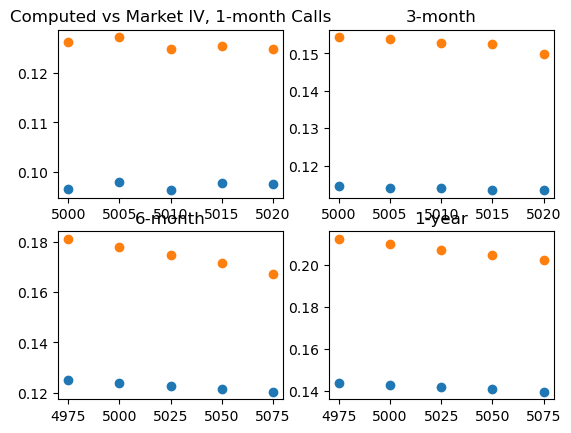

In [386]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
ax1.scatter(call_option_df['Strike'].iloc[:5],calc_call_vols[:5])
ax1.scatter(call_option_df['Strike'].iloc[:5],call_option_df['Implied Volatility'].iloc[:5])
ax1.set_title('Computed vs Market IV, 1-month Calls')

ax2.scatter(call_option_df['Strike'].iloc[5:10],calc_call_vols[5:10])
ax2.scatter(call_option_df['Strike'].iloc[5:10],call_option_df['Implied Volatility'].iloc[5:10])
ax2.set_title('3-month')

ax3.scatter(call_option_df['Strike'].iloc[10:15],calc_call_vols[10:15])
ax3.scatter(call_option_df['Strike'].iloc[10:15],call_option_df['Implied Volatility'].iloc[10:15])
ax3.set_title('6-month')

ax4.scatter(call_option_df['Strike'].iloc[15:],calc_call_vols[15:])
ax4.scatter(call_option_df['Strike'].iloc[15:],call_option_df['Implied Volatility'].iloc[15:])
ax4.set_title('1-year')
plt.show()

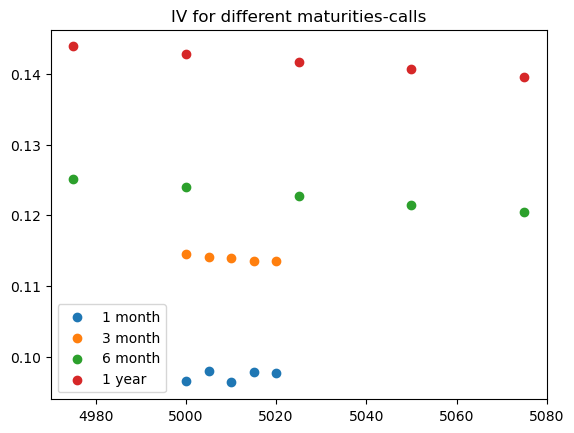

In [387]:
plt.scatter(call_option_df['Strike'].iloc[:5],calc_call_vols[:5],label = '1 month')
plt.scatter(call_option_df['Strike'].iloc[5:10],calc_call_vols[5:10], label ='3 month')
plt.scatter(call_option_df['Strike'].iloc[10:15],calc_call_vols[10:15], label='6 month') 
plt.scatter(call_option_df['Strike'].iloc[15:],calc_call_vols[15:], label = '1 year')
plt.title('IV for different maturities-calls')
plt.legend()
plt.show()

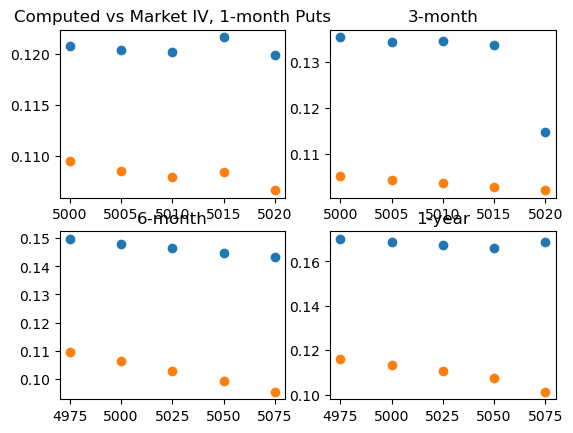

In [388]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
ax1.scatter(put_option_df['Strike'].iloc[:5],calc_put_vols[:5])
ax1.scatter(put_option_df['Strike'].iloc[:5],put_option_df['Implied Volatility'].iloc[:5])
ax1.set_title('Computed vs Market IV, 1-month Puts')

ax2.scatter(put_option_df['Strike'].iloc[5:10],calc_put_vols[5:10])
ax2.scatter(put_option_df['Strike'].iloc[5:10],put_option_df['Implied Volatility'].iloc[5:10])
ax2.set_title('3-month')

ax3.scatter(put_option_df['Strike'].iloc[10:15],calc_put_vols[10:15])
ax3.scatter(put_option_df['Strike'].iloc[10:15],put_option_df['Implied Volatility'].iloc[10:15])
ax3.set_title('6-month')

ax4.scatter(put_option_df['Strike'].iloc[15:],calc_put_vols[15:])
ax4.scatter(put_option_df['Strike'].iloc[15:],put_option_df['Implied Volatility'].iloc[15:])
ax4.set_title('1-year')
plt.show()

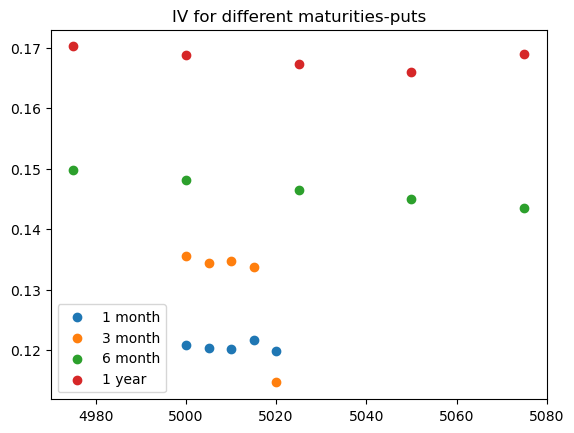

In [389]:
plt.scatter(put_option_df['Strike'].iloc[:5],calc_put_vols[:5],label = '1 month')
plt.scatter(put_option_df['Strike'].iloc[5:10],calc_put_vols[5:10], label ='3 month')
plt.scatter(put_option_df['Strike'].iloc[10:15],calc_put_vols[10:15], label='6 month') 
plt.scatter(put_option_df['Strike'].iloc[15:],calc_put_vols[15:], label = '1 year')
plt.title('IV for different maturities-puts')
plt.legend()
plt.show()

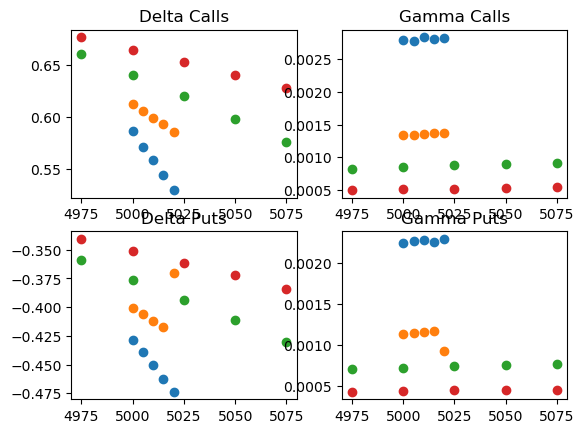

In [390]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
ax1.scatter(call_option_df['Strike'].iloc[:5],delta_calls[:5])
ax1.scatter(call_option_df['Strike'].iloc[5:10],delta_calls[5:10])
ax1.scatter(call_option_df['Strike'].iloc[10:15],delta_calls[10:15])
ax1.scatter(call_option_df['Strike'].iloc[15:],delta_calls[15:])
ax1.set_title('Delta Calls')

ax2.scatter(call_option_df['Strike'].iloc[:5],gamma_calls[:5])
ax2.scatter(call_option_df['Strike'].iloc[5:10],gamma_calls[5:10])
ax2.scatter(call_option_df['Strike'].iloc[10:15],gamma_calls[10:15])
ax2.scatter(call_option_df['Strike'].iloc[15:],gamma_calls[15:])
ax2.set_title('Gamma Calls')

ax3.scatter(call_option_df['Strike'].iloc[:5],delta_puts[:5])
ax3.scatter(call_option_df['Strike'].iloc[5:10],delta_puts[5:10])
ax3.scatter(call_option_df['Strike'].iloc[10:15],delta_puts[10:15])
ax3.scatter(call_option_df['Strike'].iloc[15:],delta_puts[15:])
ax3.set_title('Delta Puts')

ax4.scatter(call_option_df['Strike'].iloc[:5],gamma_puts[:5])
ax4.scatter(call_option_df['Strike'].iloc[5:10],gamma_puts[5:10])
ax4.scatter(call_option_df['Strike'].iloc[10:15],gamma_puts[10:15])
ax4.scatter(call_option_df['Strike'].iloc[15:],gamma_puts[15:])
ax4.set_title('Gamma Puts')
plt.show()

In [391]:
print(delta_calls)
print(gamma_calls)
print(delta_puts)
print(gamma_puts)

[0.5862906443658061, 0.5713678672037587, 0.5582664122233508, 0.5435884489454067, 0.5295980777604455, 0.6122363088764464, 0.6058699105350229, 0.5991415451305285, 0.5926555990626564, 0.5858012921627233, 0.6601213413534743, 0.6401498328108102, 0.6194947911568911, 0.5981657485534706, 0.5761318222693356, 0.6762267270612031, 0.664363659653726, 0.6522440948407515, 0.6398343269327924, 0.6271572362893274]
[0.0027921759058510357, 0.0027715002712952433, 0.0028345748837385895, 0.0028054663261169047, 0.0028188304812311648, 0.0013364502837862908, 0.0013481715332160449, 0.001354755590947194, 0.0013660829685597353, 0.0013709430631644783, 0.0008267316768335074, 0.0008525692732525973, 0.0008770512035870542, 0.0008997482827337513, 0.0009188396609342568, 0.000498982018409833, 0.0005099951667779579, 0.0005208970128543733, 0.0005314888334972567, 0.0005418339037818366]
[-0.4283482517046322, -0.4394734803991803, -0.4507845816884074, -0.4624578918278661, -0.4735638268012874, -0.40101604269192404, -0.4062189663

## Problem 1
b. We first guess a volatility and then calculate a black scholes price from this. We compare this to the actual price and if they are very different we find our next volatility using the actual price, calculated price, vega and our guess. Once they are close enough, we have found our volatility estimate. 
<br>
c. The market implied volatility is greater than the computed implied volatility in all cases.
<br>
d. As the maturity increases so does implied volatility and the lowest volatility is around the strike price and it increases as you travel away from the strike

<br>
e. They do not coincide and could create arbitrage opportunities

\begin{equation}
C-P =S-Ke^{-rT}
\end{equation}
\begin{equation}
SN(d_{1})-Ke^{-rT}N(d_{2}) -Ke^{-rT}N(-d_{2})+ SN(-d_{1})=S(N(d_{1})+N(d_{-1})) -Ke^{-rT}(N(d_{2})+N(-d_{2}))
\end{equation}
only if the volatility used in both formulas is the same does
\begin{equation}
N(d_{1})+N(d_{-1}) = 1 
\end{equation}
thus making 
\begin{equation}
C-P =S-Ke^{-rT}
\end{equation}
so implied volatility is equal for put call parity to hold.

<br>
f.
As Maturity increases, delta increases and gamma decreases for both calls and puts. As strike increase, call delta decreases and put delta decreases, while gamma increases.

## Problem 2
a.
<br>
For the Bisection method, we set a low and high point based on if a is above 1 or below one. This is because if it is above 1 then the square root is less than a and we set a as the high point, if it is below 1 we know that the solution is above a and a is the low point. We start out by setting 1 to the point that is not a. We find a midpoint between the high and low point. We then check if the midpoint squared minus a is above or below zero. if it is below we know that the midpoint is too low to be the square root of a so we set it as the new low point. If it is above zero we know that the midpoint is too high and set it as the new high point. We keep doing this until we are below our accepted error. and then the final midpoint we find is the square root of a.

<br>
<br>
For the Newton method, we again check if a is above or below 1. If below, then we have an initial guess of 2a. we have to make sure that we are above the square root value or else it will not converge. We then check to see if the guess squared minus a is greater than the error. If it is our new guess is equal to our old guess minus (our guess squared minus a)/2 times our guess. This will converge and give our last guess as the square root. If a is greater than 1 we can start from a instead because we know it will converge to our square root.
<br>
<br>


b. 
<br>
Newton's method converges within 4 iterations compared to the 19,20 iterations that the bisection method requires. This makes sense theoretically.
<br>
<br>
c.
\begin{equation}
\epsilon_{n+1}<= K\epsilon^{2}_{n}
\end{equation}
\begin{equation}
x_{n+1} = x_{n} - \frac{f(x_{n})}{f^{'}(x_{n})} , \epsilon_{n+1} = \lvert x_{n} - \frac{f(x_{n})}{f^{'}(x_{n})}-x^{*} \rvert
\end{equation}
\begin{equation}
K*\epsilon_{n}^{2} = K*(x_{n}-x^{*})^{2}
\end{equation}
\begin{equation}
\lvert x_{n} - \frac{f(x_{n})}{f^{'}(x_{n})}-x^{*} \rvert <= K*(x_{n}-x^{*})^{2}
\end{equation}
because K will make it so any value where 
\begin{equation}
x_{n}-x^{*} 
\end{equation}
does not equal 0, this holds. 
For this value equal to 0 there is no error so 0=0 and this still holds

In [436]:
def sqrt_bisection_method(a, error):
    errs = []
    logerrs = []
    if a < 1: 
        low = a
        high = 1
        i = 0
        while (high - low) > error:
            mid = (high+low)/2
            if mid**2 -a > 0 :
                high = mid
            else:
                low = mid      
            i = i+1
            err = abs(np.sqrt(a)-mid)
            errs.append(err)
            logerrs.append(np.log(err))
        result = mid
    else:
        low = 1
        high = a
        i=0
        while (high - low) > error:
            mid = (high+low)/2
            if mid**2 -a > 0:
                high = mid
            else:
                low = mid
            i=i+1
            err = abs(np.sqrt(a)-mid)
            errs.append(err)
            logerrs.append(np.log(err))
        result = mid
    return result, i, errs, logerrs
        
def sqrt_newton_method(a, error):
    errs = []
    logerrs = []
    
    if a<1:
        guess = 2*a
        i = 0
        while (guess**2-a)> error:
            guess = guess - (guess**2-a)/(2*guess)
            i=i+1
            err = abs(np.sqrt(a)-guess)
            errs.append(err)
            logerrs.append(np.log(err))
            
    else: 
        guess = a
        i = 0
        while (guess**2-a)> error:
            guess = guess - (guess**2-a)/(2*guess)
            i = i+1
            err = abs(np.sqrt(a)-guess)
            errs.append(err)
            logerrs.append(np.log(err))

    return guess, i, errs, logerrs

In [437]:
res1 = sqrt_bisection_method(.5,10**(-6))
res2 = sqrt_bisection_method(2,10**(-6))

In [438]:
res3 = sqrt_newton_method(.5,10**(-6))
res4 = sqrt_newton_method(2,10**(-6))

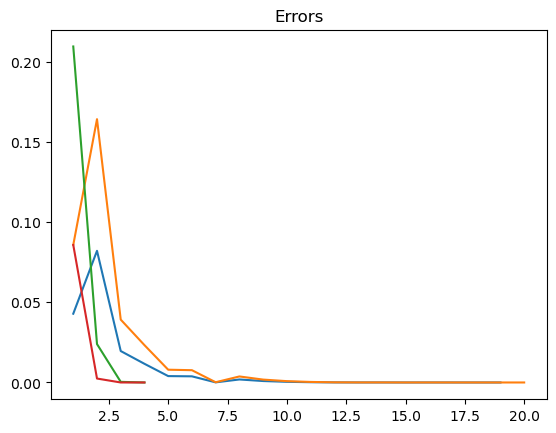

In [439]:
plt.plot(np.arange(1,res1[1]+1),res1[2])
plt.plot(np.arange(1,res2[1]+1),res2[2])
plt.plot(np.arange(1,res3[1]+1),res3[2])
plt.plot(np.arange(1,res4[1]+1),res4[2])
plt.title('Errors')
plt.show()

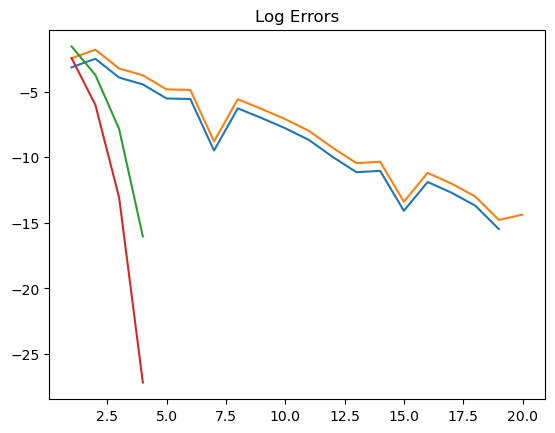

In [440]:
plt.plot(np.arange(1,res1[1]+1),res1[3])
plt.plot(np.arange(1,res2[1]+1),res2[3])
plt.plot(np.arange(1,res3[1]+1),res3[3])
plt.plot(np.arange(1,res4[1]+1),res4[3])
plt.title('Log Errors')
plt.show()

In [441]:
res3

(0.7071068900235988,
 4,
 [0.20955988548011906,
  0.023953824874058505,
  0.00039243376085384973,
  1.0883705126030208e-07],
 [-1.5627457309200348,
  -3.7316272654103857,
  -7.843142797139543,
  -16.03341401582485])

In [442]:
res4

(1.4142135623746899,
 4,
 [0.08578643762690485,
  0.002453104293571595,
  2.1239014147411694e-06,
  1.5947243525715749e-12],
 [-2.4558943545990326,
  -6.010400997866181,
  -13.062255870567075,
  -27.164320214331127])